
üß† OpenAI responde:

El dataset presenta 5000 registros y 13 columnas, lo que indica un tama√±o adecuado para an√°lisis. Sin embargo, se identifican 888 valores nulos, lo que representa aproximadamente el 17.76% del total de datos. Esto podr√≠a impactar negativamente en los resultados de cualquier an√°lisis estad√≠stico, ya que hay una cantidad significativa de datos faltantes que podr√≠an ser cruciales para la interpretaci√≥n.

Adem√°s, no se encuentran duplicados, lo que es positivo. No obstante, los outliers en campos como 'Rank', '$Worldwide', '$Domestic', '$Foreign', y 'Vote_Count' requieren atenci√≥n, especialmente los outliers en '$Worldwide' y 'Vote_Count', que podr√≠an influir desproporcionadamente en las estad√≠sticas generales del dataset.

Se aconseja realizar una imputaci√≥n de datos para manejar los valores nulos, considerando t√©cnicas como la imputaci√≥n por medias, medianas o utilizando modelos predictivos. Adicionalmente, se debe investigar m√°s a fondo los outlier

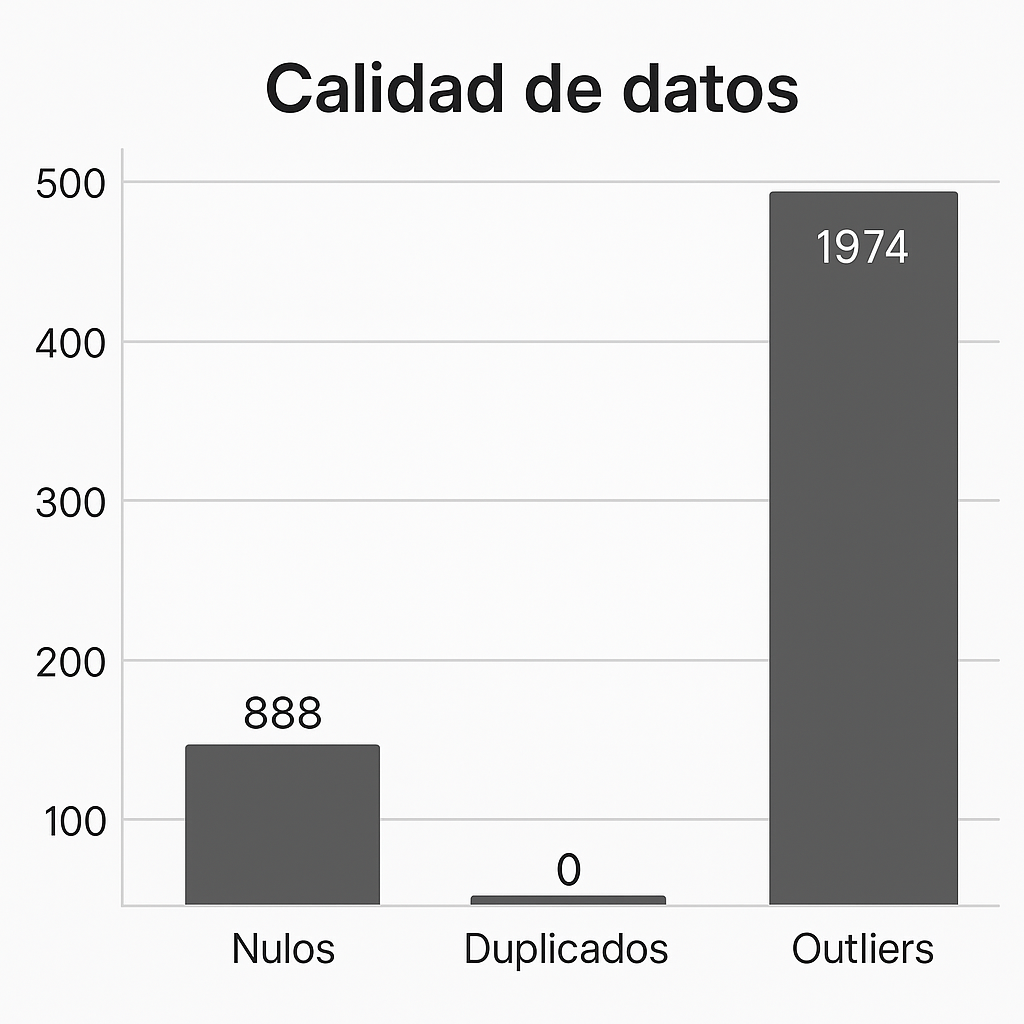

In [4]:
import pandas as pd
import os
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import display
import base64
from PIL import Image
import io


load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_KEY:
    print("‚ö†Ô∏è Falta la clave de OpenAI en el archivo .env")


client = OpenAI(api_key=OPENAI_KEY)

csv_path = "dataset.csv"   
df = pd.read_csv(csv_path)



nulos = df.isnull().sum().sum()
duplicados = df.duplicated().sum()


outliers = {}
for col in df.select_dtypes(include=["int64", "float64"]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers[col] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()


prompt_texto = f"""
Analiza este dataset y detecta problemas de calidad:
- Tama√±o: {df.shape}
- Nulos: {nulos}
- Duplicados: {duplicados}
- Outliers: {outliers}


Responde de forma breve y clara, en varios renglones.
Por ultimo da un breve consejo de que hacer segun como esten esos datos.
"""

if OPENAI_KEY:
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Eres un experto en an√°lisis de datos."},
                {"role": "user", "content": prompt_texto}
            ],
            max_tokens=300
        )
        print("\nüß† OpenAI responde:\n")
        print(response.choices[0].message.content)
    except Exception as e:
        print("‚ùå Error con OpenAI:", e)



prompt_visual = (
    f"Genera un gr√°fico de barras que muestre tres problemas de calidad de datos. "
    f"Categor√≠as: 'Nulos' ({nulos}), 'Duplicados' ({duplicados}), 'Outliers' ({sum(outliers.values())}). "
    "Cada barra debe incluir el n√∫mero exacto encima o dentro de la barra. "
    "El dise√±o debe ser simple, con etiquetas claras en espa√±ol, fondo blanco, colores sobrios, "
    "y t√≠tulo 'Calidad de datos'."
)

try:
    result = client.images.generate(
        model="gpt-image-1",
        prompt=prompt_visual,
        size="auto"
    )

    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)

    img = Image.open(io.BytesIO(image_bytes))
    display(img)
    img.save("infografia_calidad.png")
except Exception as e:
    print("‚ùå Error al generar imagen con OpenAI:", e)



